## CMA-ES for CartPole Torch (assignment version)
### Christian Igel, 2024

If you have suggestions for improvement, [let me know](mailto:igel@diku.dk).

You may need the following packages:

``pip install gymnasium[classic-control]``

``python -m pip install cma``

In [31]:
import gymnasium as gym  # Defines RL environments

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4,4)  # Set size of visualization
from IPython.display import clear_output  # For inline visualization

import torch
import torch.nn as nn
import torch.nn.functional as F

import cma

# Define task
env = gym.make('CartPole-v1')
state_space_dimension = env.observation_space.shape[0]
action_space_dimension = 1  # env.action_space.n - 1

Define the policy network:

In [32]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=5, use_bias=True):
        super().__init__()
        # Hidden layer: a linear layer followed by tanh activation
        self.hidden = nn.Linear(input_dim, hidden_dim, bias=use_bias)
        # Output layer: a single neuron with linear activation
        self.output = nn.Linear(hidden_dim, 1, bias=use_bias)
        
    def forward(self, x):
        x = torch.tanh(self.hidden(x))
        x = self.output(x)  # Linear output
        return x

# Instantiate the policy network.
# Set 'use_bias' to True for an architecture with trainable biases,
# or False to have no bias parameters.
policy_net = PolicyNetwork(state_space_dimension, hidden_dim=5, use_bias=True)

Compute number of parameters:

In [33]:
d = sum(
	param.numel() for param in policy_net.parameters()
)
print("Number of parameters:", d)

Number of parameters: 31


Helper function for visualization:

In [34]:
def visualize_policy(policy_net):
    env_render = gym.make('CartPole-v1', render_mode='rgb_array')
    state = env_render.reset()  # Forget about previous episode
    state_tensor = torch.Tensor( state[0].reshape((1, state_space_dimension)) )
    steps = 0
    while True:
        out = policy_net(state_tensor)
        a = int(out > 0)
        state, reward, terminated, truncated, _ = env_render.step(a)  # Simulate pole
        steps+=1
        state_tensor = torch.Tensor( state.reshape((1, state_space_dimension)) )
        clear_output(wait=True)
        plt.imshow(env_render.render())
        plt.show()
        print("step:", steps)
        if(terminated or truncated): 
            break
    env_render.close()
    return

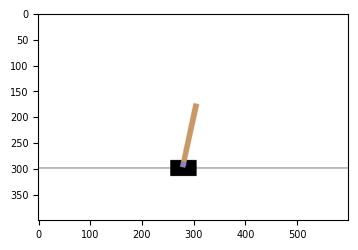

step: 9


In [35]:
visualize_policy(policy_net)

Now we define the objective/reward function. 
When the task is solved the functions returns -1000.
One successful trial is sufficient.

In [36]:
def fitness_cart_pole(x, nn, env):
    '''
    Returns negative accumulated reward for single pole, fully environment.

    Parameters:
        x: Parameter vector encoding the weights.
        nn: Parameterized model.
        env: Environment ('CartPole-v?').
    '''
    torch.nn.utils.vector_to_parameters(torch.Tensor(x), nn.parameters())  # Set the policy parameters
    
    state = env.reset()  # Forget about previous episode
    state_tensor = torch.Tensor( state[0].reshape((1, state_space_dimension)) )
          
    R = 0  # Accumulated reward
    while True:
        out = nn(state_tensor)
        a = int(out > 0)
        state, reward, terminated, truncated, _ = env.step(a)  # Simulate pole
        state_tensor = torch.Tensor( state.reshape((1, state_space_dimension)) )
        R += reward  # Accumulate 
        if truncated:
            return -1000  # Episode ended, final goal reached, we consider minimization
        if terminated:
            return -R  # Episode ended, we consider minimization
    return -R  # Never reached  

Do the learning:

In [37]:
# Generate initial search point and initial hidden RNN states
initial_weights = np.random.normal(0, 0.01, d)  # Random parameters for initial policy, d denotes the number of weights
initial_sigma = .01 # Initial global step-size sigma

# Do the optimization
res = cma.fmin(fitness_cart_pole,  # Objective function
               initial_weights,  # Initial search point
               initial_sigma,  # Initial global step-size sigma
               args=([policy_net, env]),  # Arguments passed to the fitness function
               options={'ftarget': -999.9, 'tolflatfitness':1000, 'eval_final_mean':False})
env.close()

# Set the policy parameters to the final solution
torch.nn.utils.vector_to_parameters(torch.Tensor(res[0]), policy_net.parameters())  

print("best solution found after", res[2], "evaluations")

(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 31 (seed=463438, Mon Feb 24 17:57:44 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.100000000000000e+01 1.0e+00 9.37e-03  9e-03  9e-03 0:00.0
    2     28 -1.100000000000000e+01 1.1e+00 8.94e-03  9e-03  9e-03 0:00.0
    3     42 -1.000000000000000e+01 1.1e+00 8.83e-03  9e-03  9e-03 0:00.1
  100   1400 -1.100000000000000e+01 2.0e+00 7.39e-03  7e-03  8e-03 0:01.9
  183   2562 -1.680000000000000e+02 3.3e+00 9.72e-03  6e-03  1e-02 0:05.9
  200   2800 -1.650000000000000e+02 3.6e+00 9.16e-03  5e-03  1e-02 0:07.4
  222   3108 -1.000000000000000e+03 4.4e+00 1.32e-02  6e-03  2e-02 0:10.8
termination on ftarget=-999.9 (Mon Feb 24 17:57:55 2025)
final/bestever f-value = -1.000000e+03 -1.000000e+03 after 3108/3095 evaluations
incumbent solution: [-0.01888601 -0.10668435  0.08159709 -0.16399389  0.0189794   0.1347795
 -0.00195905 -0.13510997 ...]
std deviations: [0.01285658 0.01374876 0.01362982 0.014313

Render solution:

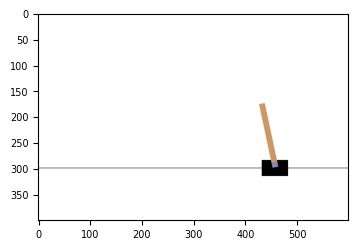

step: 362


In [38]:
visualize_policy(policy_net)

Learn more about CMA-ES optimization:

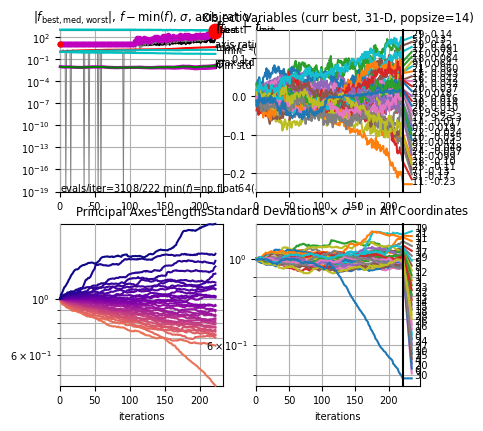

In [39]:
# Visualize the optimization 
cma.plot();  

In [40]:
# Learn even more on CMA-ES
cma.CMAOptions() 

{'AdaptSigma': 'True  # or False or any CMAAdaptSigmaBase class e.g. CMAAdaptSigmaTPA, CMAAdaptSigmaCSA',
 'CMA_active': 'True  # negative update, conducted after the original update',
 'CMA_active_injected': '0  #v weight multiplier for negative weights of injected solutions',
 'CMA_cmean': '1  # learning rate for the mean value',
 'CMA_const_trace': 'False  # normalize trace, 1, True, "arithm", "geom", "aeig", "geig" are valid',
 'CMA_diagonal': '0*100*N/popsize**0.5  # nb of iterations with diagonal covariance matrix, True for always',
 'CMA_diagonal_decoding': '0  # learning rate multiplier for additional diagonal update',
 'CMA_eigenmethod': 'np.linalg.eigh  # or cma.utilities.math.eig or pygsl.eigen.eigenvectors',
 'CMA_elitist': 'False  #v or "initial" or True, elitism likely impairs global search performance',
 'CMA_injections_threshold_keep_len': '1  #v keep length if Mahalanobis length is below the given relative threshold',
 'CMA_mirrors': 'popsize < 6  # values <0.5 are int

### Bias vs No bias
Compare the performance of the two different architectures. Repeat the learning ten times with and ten times without bias parameters. How long does it take on average to find a solution, that is, a network that balances from a starting position for 500 steps, in the two settings? If you try the 20 solutions again from a random starting position, how long do they balance the pole on average depending on whether bias parameters are used? How do you explain your observations?

In [41]:
def evaluate_policy_balance(policy_net, env, n_runs=5):
    """
    Run n_runs episodes with the given policy and return the average steps balanced.
    No plotting is performed.
    """
    total_steps = 0
    for _ in range(n_runs):
        state = env.reset()[0]
        state_tensor = torch.Tensor(state.reshape((1, state_space_dimension)))
        steps = 0
        while True:
            with torch.no_grad():
                out = policy_net(state_tensor)
            a = int(out > 0)
            state, reward, terminated, truncated, _ = env.step(a)
            steps += 1
            state_tensor = torch.Tensor(np.array(state).reshape((1, state_space_dimension)))
            if terminated or truncated:
                total_steps += steps
                break
    return total_steps / n_runs

def run_experiment(use_bias, n_repeats=10):
    evals_list = []
    balance_steps_list = []
    for i in range(n_repeats):
        # Instantiate new network with or without bias (hidden_dim=5)
        net = PolicyNetwork(state_space_dimension, hidden_dim=5, use_bias=use_bias)
        # Determine parameter vector length for this architecture:
        param_count = sum(p.numel() for p in net.parameters())
        # Generate new initial parameters
        init_w = np.random.normal(0, 0.01, param_count)
        # Run CMA-ES optimization; note: we use the same env variable
        result = cma.fmin(
            fitness_cart_pole,        # Fitness function
            init_w,                   # Initial search point
            initial_sigma,            # Initial sigma
            args=([net, env]),         # Additional args: model and environment
            options={'ftarget': -999.9, 'tolflatfitness': 1000, 'eval_final_mean': False}
        )
        # Get the number of evaluations to solution:
        evaluations = result[2]
        evals_list.append(evaluations)
        # Set final solution parameters to network:
        torch.nn.utils.vector_to_parameters(torch.Tensor(result[0]), net.parameters())
        # Evaluate solution performance over a few episodes
        avg_steps = evaluate_policy_balance(net, env, n_runs=5)
        balance_steps_list.append(avg_steps)
        print(f"Repeat {i+1}: evaluations = {evaluations}, avg steps balanced = {avg_steps:.1f}")
    return np.mean(evals_list), np.mean(balance_steps_list)

print("Running experiment with bias parameters (use_bias=True):")
avg_evals_bias, avg_steps_bias = run_experiment(use_bias=True, n_repeats=10)
print("\nRunning experiment without bias parameters (use_bias=False):")
avg_evals_no_bias, avg_steps_no_bias = run_experiment(use_bias=False, n_repeats=10)

print("\nSummary of results:")
print(f"With bias:    average evaluations = {avg_evals_bias:.1f}, average balancing steps = {avg_steps_bias:.1f}")
print(f"Without bias: average evaluations = {avg_evals_no_bias:.1f}, average balancing steps = {avg_steps_no_bias:.1f}")

Running experiment with bias parameters (use_bias=True):
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 31 (seed=591150, Mon Feb 24 17:58:32 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     14 -1.000000000000000e+01 1.0e+00 9.60e-03  1e-02  1e-02 0:00.0
    2     28 -1.100000000000000e+01 1.1e+00 9.18e-03  9e-03  9e-03 0:00.0
    3     42 -1.100000000000000e+01 1.1e+00 8.92e-03  9e-03  9e-03 0:00.1
   51    714 -1.000000000000000e+03 1.7e+00 6.38e-03  6e-03  7e-03 0:01.4
termination on ftarget=-999.9 (Mon Feb 24 17:58:34 2025)
final/bestever f-value = -1.000000e+03 -1.000000e+03 after 714/703 evaluations
incumbent solution: [-0.00259863 -0.00051525  0.03597693  0.02147747  0.01243138  0.03588185
 -0.00988282  0.04775443 ...]
std deviations: [0.00631625 0.00620281 0.00630608 0.00610079 0.00647229 0.00645345
 0.00625473 0.00660533 ...]
Repeat 1: evaluations = 703, avg steps balanced = 418.6
(7_w,14)-aCMA-ES (mu_w=4.3,w_1=36%) in dimension 31 (seed